# **Fraud Transaction Detection Using Machine Learning**

## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             auc, f1_score, average_precision_score, precision_score, recall_score)
import shap
import warnings
warnings.filterwarnings('ignore')

#### **Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Load Dataset**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Project/Fraud Detection/Fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


## **Basic Data Understanding**

#### Feature Description (Data Dictionary)

**1. `step`**
- Represents the time of the transaction  
- 1 step = 1 hour  
- Total of 744 steps (30 days simulation)  
- **Helps identify time-based fraud patterns**  

---

**2. `type`**
- Type of transaction  
- Possible values:
  - CASH-IN
  - CASH-OUT
  - DEBIT
  - PAYMENT
  - TRANSFER  
- **Fraud mostly occurs in TRANSFER and CASH-OUT transactions**  

---

**3. `amount`**
- Amount of money involved in the transaction  
- **High-value transactions are more likely to be fraudulent**  

---

**4. `nameOrig`**
- Unique ID of the customer who initiated the transaction  
- Used only for identification  
- Not directly useful for model prediction  

---

**5. `oldbalanceOrg`**
- Balance of the sender before the transaction
- **Helps verify whether the transaction amount is logical**  

---

**6. `newbalanceOrig`**
- Balance of the sender after the transaction  
- **Sudden balance drop may indicate fraudulent activity**  

---

**7. `nameDest`**
- Unique ID of the transaction recipient  
- IDs starting with 'M' indicate merchants  
- **Mainly used for identification purposes**  

---

**8. `oldbalanceDest`**
- Balance of the receiver before the transaction
- Not available for merchant accounts  
- **Useful for detecting abnormal balance changes**  

---

**9. `newbalanceDest`**
- Balance of the receiver after the transaction  
- **Sudden increase in balance can indicate fraud**  

---

**10. `isFraud`**
- Target variable indicating fraudulent transactions  
- 1 → Fraudulent transaction  
- 0 → Normal transaction  

---

**11. `isFlaggedFraud`**
- Rule-based fraud indicator  
- Flags transactions where amount > 200,000  
- Should not be used as an input feature to avoid data leakage  

In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df.groupby('type')['amount'].agg(['count', 'mean', 'std']) .sort_values(by='std', ascending=False)

,count,mean,std
type,,,
TRANSFER,532909,910647.009645,1.879574e+06
CASH_OUT,2237500,176273.964346,1.753297e+05
CASH_IN,1399284,168920.242004,1.265083e+05
DEBIT,41432,5483.665314,1.331854e+04
PAYMENT,2151495,13057.604660,1.255645e+04


**Count fraud cases**

In [8]:
df[df['isFraud'] == 1].groupby('type')['isFraud'].count()

,isFraud
type,
CASH_OUT,4116
TRANSFER,4097


## **Check Class Imbalance**

In [9]:
df['isFraud'].value_counts(normalize=True) * 100

,proportion
isFraud,
0,99.870918
1,0.129082


**Class Imbalance**

- **Problem:**

   - Model may get biased toward the majority class

   - Accuracy becomes misleading

 - **Solution:**

    - Used `class_weight = 'balanced'` in the model

 - **Reason:**

    - Assigns higher penalty to misclassified fraud cases

   - Improves recall for the minority (fraud) class

## **Check Missing Values**

In [10]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Note : There are NO missing values in any column of the dataset

## **Check Duplicate Value**

In [11]:
df.duplicated().sum()

np.int64(0)

Note : There are NO Duplicate values in the dataset

## **Outlier Detection**

In [12]:
def detect_outliers_iqr(data, column, multiplier=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

In [13]:
for trans_type in df['type'].unique():
    subset = df[df['type'] == trans_type]
    outliers = detect_outliers_iqr(subset, 'amount')
    print(f"{trans_type}: {len(outliers)} outliers detected")

PAYMENT: 111703 outliers detected
TRANSFER: 39793 outliers detected
CASH_OUT: 49220 outliers detected
DEBIT: 3038 outliers detected
CASH_IN: 27829 outliers detected


## **Multicollinearity Check**

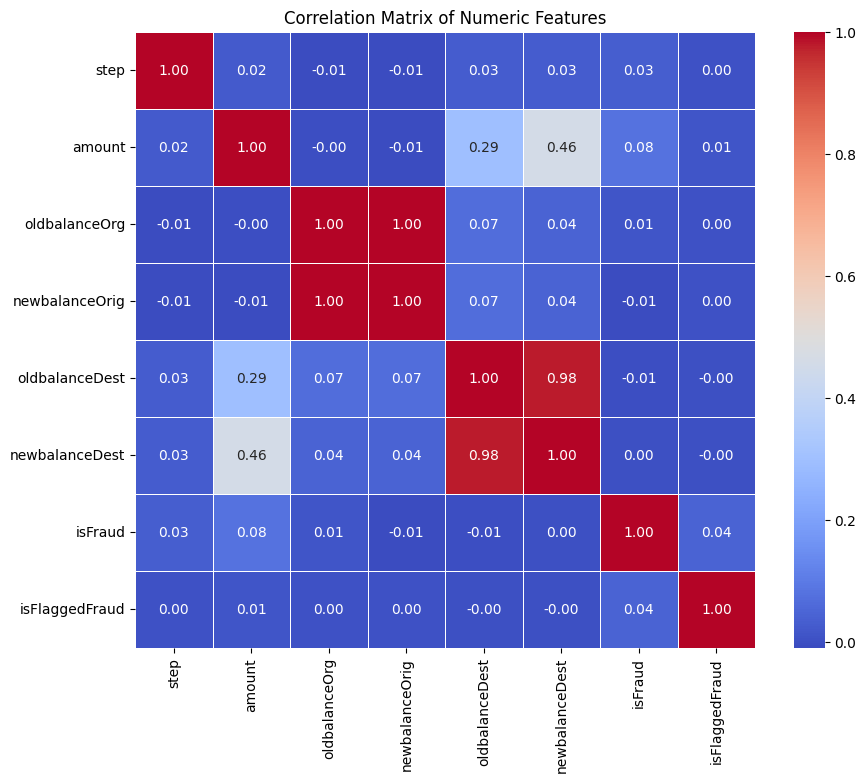

In [14]:
numeric_cols = [
    'step', 'amount',
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'isFraud', 'isFlaggedFraud'
]

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,        # show values
    fmt=".2f",         # 2 decimal places
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

#### **Variance Inflation Factor (VIF)**

In [15]:
X = df[['step', 'amount','oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest']]

vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])]

In [16]:
vif_df

,feature,VIF
0,step,1.188495
1,amount,4.011315
2,oldbalanceOrg,465.122355
3,newbalanceOrig,466.903890
4,oldbalanceDest,71.765327
5,newbalanceDest,83.231611


## **Feature Engineering**

In [17]:
df['balance_spent_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['balance_drained'] = (df['oldbalanceOrg'] - df['newbalanceOrig']) > (df['oldbalanceOrg'] * 0.5)

In [18]:
df['hour_of_day'] = df['step'] % 24
df['day_of_month'] = df['step'] // 24 + 1
df['is_night'] = (df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 6)

### **Encode Categorical Variable**

In [19]:
type_dummies = pd.get_dummies(df['type'], prefix='type')

type_fraud_risk = df.groupby('type')['isFraud'].mean()
df['type_fraud_risk'] = df['type'].map(type_fraud_risk)

In [20]:
df['is_merchant_dest'] = df['nameDest'].str.startswith('M').astype(int)

In [21]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_spent_ratio,balance_drained,hour_of_day,day_of_month,is_night,type_fraud_risk,is_merchant_dest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.057834,False,1,1,True,0.000000,1
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.087731,False,1,1,True,0.000000,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.994505,True,1,1,True,0.007688,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.994505,True,1,1,True,0.001840,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.280788,False,1,1,True,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.999997,True,23,31,True,0.001840,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,1.000000,True,23,31,True,0.007688,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,1.000000,True,23,31,True,0.001840,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.999999,True,23,31,True,0.007688,0


#### **Drop Feature**

In [22]:
df = df.drop(['nameOrig', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis=1)

Note : “VIF analysis showed very high multicollinearity among balance-related variables such as oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest, as post-transaction balances are directly derived from pre-transaction balances. To reduce redundancy and improve model stability and interpretability, these highly collinear variables were removed and replaced with engineered features capturing balance changes, which retain the same information with significantly lower multicollinearity.”

In [23]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud,balance_spent_ratio,balance_drained,hour_of_day,day_of_month,is_night,type_fraud_risk,is_merchant_dest
0,1,PAYMENT,9839.64,0,0,0.057834,False,1,1,True,0.000000,1
1,1,PAYMENT,1864.28,0,0,0.087731,False,1,1,True,0.000000,1
2,1,TRANSFER,181.00,1,0,0.994505,True,1,1,True,0.007688,0
3,1,CASH_OUT,181.00,1,0,0.994505,True,1,1,True,0.001840,0
4,1,PAYMENT,11668.14,0,0,0.280788,False,1,1,True,0.000000,1


## **Prepare Features & Target**

In [24]:
X = df.drop(['isFraud', 'type', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

**`isFlaggedFraud` is a rule-based flag created by the system**    
**Reason :** Using it means the model is “cheating” by seeing a decision made elsewhere

In [25]:
X

,step,amount,balance_spent_ratio,balance_drained,hour_of_day,day_of_month,is_night,type_fraud_risk,is_merchant_dest
0,1,9839.64,0.057834,False,1,1,True,0.000000,1
1,1,1864.28,0.087731,False,1,1,True,0.000000,1
2,1,181.00,0.994505,True,1,1,True,0.007688,0
3,1,181.00,0.994505,True,1,1,True,0.001840,0
4,1,11668.14,0.280788,False,1,1,True,0.000000,1
...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,0.999997,True,23,31,True,0.001840,0
6362616,743,6311409.28,1.000000,True,23,31,True,0.007688,0
6362617,743,6311409.28,1.000000,True,23,31,True,0.001840,0
6362618,743,850002.52,0.999999,True,23,31,True,0.007688,0


### **Train-Test Split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### **Scale features**

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **MODEL - Logistic Regression**

In [ ]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_pred_lr = lr.predict(X_test_scaled)

### **MODEL PERFORMANCE DEMONSTRATION**

#### **Model Evaluation**


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1906322
           1       0.01      0.94      0.02      2464

    accuracy                           0.87   1908786
   macro avg       0.50      0.90      0.47   1908786
weighted avg       1.00      0.87      0.93   1908786





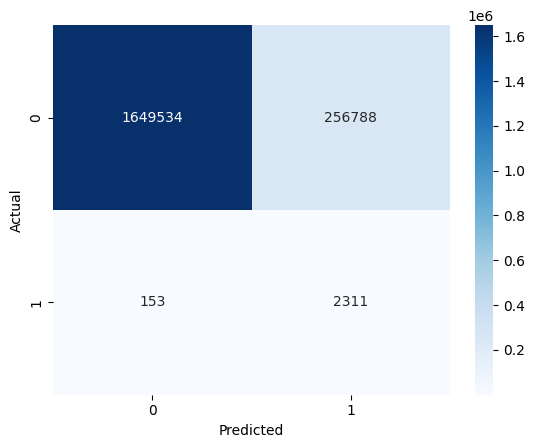



ROC-AUC: 0.9703
PR-AUC: 0.0903


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\n")
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n")
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob_lr)
pr_auc  = average_precision_score(y_test, y_prob_lr)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

#### **Threshold Optimization**

In [ ]:
thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_prob_lr >= threshold).astype(int)

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

optimal_threshold = results_df.loc[results_df['f1'].idxmax(), 'threshold']

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(results_df.loc[results_df['f1'].idxmax()])

Optimal threshold: 0.90
threshold    0.900000
precision    0.045268
recall       0.618101
f1           0.084358
Name: 16, dtype: float64


#### **Cost-Benefit Analysis**

In [ ]:
cost_fn = 1000
cost_fp = 10

cost_analysis = []
for threshold in thresholds:
    y_pred_thresh = (y_prob_lr >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    total_cost = (fn * cost_fn) + (fp * cost_fp)
    cost_analysis.append({
        'threshold': threshold,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'total_cost': total_cost,
        'fraud_caught_pct': tp / (tp + fn) * 100
    })

cost_df = pd.DataFrame(cost_analysis)
optimal_threshold_cost = cost_df.loc[cost_df['total_cost'].idxmin(), 'threshold']

print(f"Cost-optimal threshold: {optimal_threshold_cost:.2f}")
print(f"Fraud catch rate: {cost_df.loc[cost_df['threshold'] == optimal_threshold_cost, 'fraud_caught_pct'].values[0]:.2f}%")

Cost-optimal threshold: 0.85
Fraud catch rate: 69.85%


#### **Feature Importance**

In [ ]:
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
})

feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()

feature_importance_lr = feature_importance_lr.sort_values(
    by='Abs_Coefficient',
    ascending=False
)

feature_importance_lr

,Feature,Coefficient,Abs_Coefficient
8,is_merchant_dest,-6.187513,6.187513
3,balance_drained,2.210770,2.210770
2,balance_spent_ratio,-0.663655,0.663655
6,is_night,0.571506,0.571506
1,amount,0.558514,0.558514
7,type_fraud_risk,0.508397,0.508397
4,hour_of_day,-0.376489,0.376489
5,day_of_month,0.234647,0.234647
0,step,0.222887,0.222887


#### **Feature Importance Analysis (SHAP)**

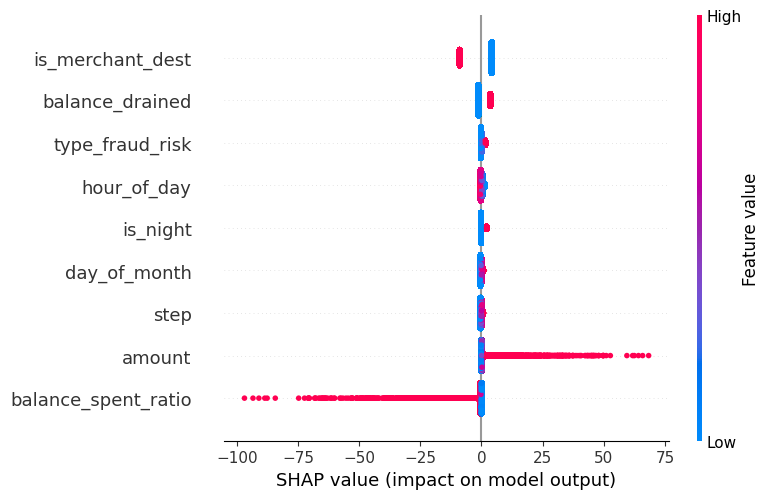

In [ ]:
shap.initjs()

explainer = shap.LinearExplainer(
    lr,
    X_train_scaled,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(
    shap_values,
    X_test_scaled,
    feature_names=X_train.columns,
    show=True
)

shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test_scaled[0],
    feature_names=X_train.columns,
    show=True
)

## **MODEL - Random Forest**

In [28]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Note: Random Forest does not require scaling

In [29]:
y_pred_rf = rf.predict(X_test)

### **Model Performance Demonstration**

#### **Model Evaluation**


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      0.99      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786





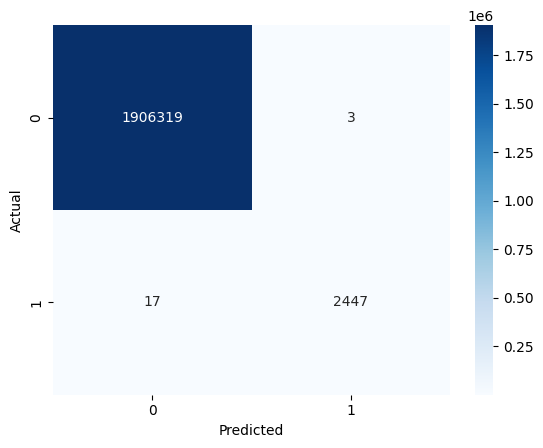



ROC-AUC: 0.9982
PR-AUC: 0.9963


In [30]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\n")
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n")
y_prob_rf = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob_rf)
pr_auc  = average_precision_score(y_test, y_prob_rf)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

#### **Threshold Optimization**

In [31]:
thresholds = np.arange(0.1, 0.95, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_prob_rf >= threshold).astype(int)

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

results_df = pd.DataFrame(results)

optimal_threshold = results_df.loc[results_df['f1'].idxmax(), 'threshold']

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(results_df.loc[results_df['f1'].idxmax()])

Optimal threshold: 0.50
threshold    0.500000
precision    0.998776
recall       0.993101
f1           0.995930
Name: 8, dtype: float64


#### **Cost-Benefit Analysis**

In [32]:
cost_fn = 1000
cost_fp = 10

cost_analysis = []
for threshold in thresholds:
    y_pred_thresh = (y_prob_rf >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    total_cost = (fn * cost_fn) + (fp * cost_fp)
    cost_analysis.append({
        'threshold': threshold,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'total_cost': total_cost,
        'fraud_caught_pct': tp / (tp + fn) * 100
    })

cost_df = pd.DataFrame(cost_analysis)
optimal_threshold_cost = cost_df.loc[cost_df['total_cost'].idxmin(), 'threshold']

print(f"Cost-optimal threshold: {optimal_threshold_cost:.2f}")
print(f"Fraud catch rate: {cost_df.loc[cost_df['threshold'] == optimal_threshold_cost, 'fraud_caught_pct'].values[0]:.2f}%")

Cost-optimal threshold: 0.15
Fraud catch rate: 99.63%


#### **Feature Importance**

In [33]:
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})

feature_importance_rf = feature_importance_rf.sort_values(
    by='Importance',
    ascending=False
)

feature_importance_rf

,Feature,Importance
2,balance_spent_ratio,0.476746
3,balance_drained,0.267275
7,type_fraud_risk,0.143341
1,amount,0.049884
8,is_merchant_dest,0.023280
0,step,0.016349
5,day_of_month,0.012212
4,hour_of_day,0.008892
6,is_night,0.002022


## **Top Fraud Indicators (Ranked)**


### **Rank 1: Transaction Type (TRANSFER & CASH_OUT)**

 - Dataset analysis shows that nearly all fraud cases occur in TRANSFER and CASH_OUT transactions

    - CASH_OUT: 4,116 fraud cases

    - TRANSFER: 4,097 fraud cases

- Negligible fraud observed in PAYMENT, DEBIT, and CASH_IN types

#### **Interpretation:**
Fraudsters typically move funds using TRANSFER transactions and then withdraw money using CASH_OUT, making these transaction types the highest-risk categories.







### **Rank 2: Balance Drained (`balance_drained`)**

  - Strong positive coefficient (~2.21)

 - SHAP confirms high contribution toward fraud prediction

 - Indicates whether a large portion of balance is removed in one or few transactions

#### **Interpretation:**
Fraudsters attempt to empty accounts rapidly once access is gained.

### **Rank 3: Balance Spent Ratio (`balance_spent_ratio`)**

 - High importance in SHAP summary plot

 - Large ratios strongly push predictions toward fraud

 - Represents proportion of account balance spent in a transaction

#### **Interpretation:**
Legitimate users rarely spend a very large fraction of their balance at once, whereas fraud cases show aggressive balance depletion.

### **Rank 4: Transaction Amount (`amount`)**

 - Positive coefficient (~0.56)

 - SHAP shows high-value transactions increase fraud probability

#### **Interpretation:**
Fraudulent transactions typically involve larger amounts to maximize financial gain before detection.

### **Rank 5: Transaction Type Risk (`type_fraud_risk`)**

 - Meaningful coefficient (~0.51)

 - Certain transaction types contribute more to fraud likelihood

#### **Interpretation:**
Specific transaction categories are inherently riskier and are more frequently exploited in fraud scenarios.

### **Rank 6: Night-Time Transactions (`is_night`)**

 - Moderate positive coefficient (~0.57)

 - SHAP indicates slight increase in fraud probability during night hours

#### **Interpretation:**
Fraud activity is marginally higher during off-hours when users are less likely to notice unauthorized transactions.

### **Rank 7: Time-Based Features (`hour_of_day`, `day_of_month`, `step`)**

 - Low absolute coefficients

 - SHAP impact close to zero

#### **Interpretation:**
Calendar and sequence-based timing features play a secondary role compared to behavioral and financial indicators.

## **Do these factors make sense?**
### **(A) Logical Consistency Check**

✅ YES – The identified factors align well with real-world fraud behavior

#### **1. TRANSFER + CASH_OUT combination:**
 - **Why it makes sense:** Fraudsters steal account → transfer to confederate → cash out
 - **Real-world validation:** This pattern aligns with well-known fraud modus operandi.
 - **Evidence:** Dataset analysis shows that almost all fraudulent transactions occur in TRANSFER and CASH_OUT transaction types, with negligible fraud in other types.

2. Balance Draining & High Spend Ratio**

  - **Why it makes sense:**  Legitimate users maintain balance buffers; fraudsters attempt rapid extraction

  - **Real-world validation:** Fraud is typically fast and aggressive

  - **Evidence:** High coefficients + strong SHAP impact

#### **3. Large Transaction Amounts**

  - **Why it makes sense:** Fraudsters maximize loss before detection

  - **Real-world validation:** High-value transactions are always higher risk

 - **Evidence:** Positive coefficient and right-shifted SHAP values

#### **4. Risky Transaction Types**

  - **Why it makes sense:** Certain transaction mechanisms are easier to exploit

  - **Real-world validation:**  Financial institutions maintain type-based risk scoring

  - **Evidence:** Consistent importance across LR and SHAP

#### **5. Off-Hours Transactions**

  - **Why it makes sense:** Fraudsters exploit periods of low user vigilance

  - **Real-world validation:**  Many fraud attacks occur late night

  - **Evidence:** Moderate but consistent contribution

### **(B) Potential False Signals (Caveats)**

⚠️ Model limitations to consider:

#### **Case: Large transaction amount**

 - **Problem:** Businesses make large legitimate transfers

 - **Risk:** Model may flag them as fraud

 - **Caveat:** Amount alone is not enough

## **Prevention Strategies & Infrastructure Updates**

### **1. Real-Time Detection & Blocking**
👉**HOW a single transaction is decided**


```
# REAL-TIME FRAUD DETECTION PIPELINE

def real_time_fraud_check(transaction, model, threshold=0.70):

    """
    Real-time fraud check for incoming transaction
    Returns: 'APPROVE', 'REVIEW', 'BLOCK' decision
    """


    features = engineer_features(transaction)
    probability = model.predict_proba(features)[0][1]
    
    if probability > threshold:
        return {
            'decision': 'BLOCK',
            'fraud_probability': probability,
            'reason': 'High-risk transaction pattern detected'
        }
    elif probability > 0.50:
        return {
            'decision': 'REVIEW',
            'fraud_probability': probability,
            'reason': 'Requires additional verification'
        }
    else:
        return {
            'decision': 'APPROVE',
            'fraud_probability': probability
        }
```

### **2. Recommended Prevention Controls**
👉 **WHAT controls exist in the system**

- **Layer 1: Transaction Rules (Rule-Based Blocking)**

```
IF type IN ('TRANSFER', 'CASH_OUT') AND amount > 200,000 THEN BLOCK
IF balance_spent_ratio > 0.7 THEN FLAG FOR REVIEW
IF hour_of_day IN (22-23, 0-6) AND amount > median_amount THEN REQUIRE_OTP
IF customer_trans_count < 5 AND amount > 50,000 THEN REQUIRE_VERIFICATION
```

 - **Layer 2: ML-Based Scoring (Probabilistic)**
```
IF fraud_probability > 0.70 THEN BLOCK
IF fraud_probability IN (0.50, 0.70) THEN CHALLENGE_USER (OTP, security questions)
IF fraud_probability > 0.30 THEN MONITOR (log for pattern detection)
```

 - **Layer 3: Behavioral Anomalies**
```
IF deviation_from_historical > 3_sigma THEN FLAG
IF account_compromise_score > threshold THEN FREEZE_ACCOUNT
IF rapid_transaction_sequence (>5 txns in 1 hour) THEN INVESTIGATE
```
- **Layer 4: Cross-Transaction Patterns**
```
IF (TRANSFER to account X) FOLLOWED_BY (CASH_OUT from X) within 60_mins
   THEN HIGH_CONFIDENCE_FRAUD
IF multiple_accounts → same_merchant THEN POTENTIAL_RING (circular fraud)
```

### **3. Implementation Roadmap**
👉 **WHEN and HOW to build it**

```
Week 1-2: Deploy rule-based controls (Layer 1)
  - Configure amount limits, type restrictions
  - Set up real-time rules engine
  - Establish baseline for false positives

Week 3-4: Integrate ML model (Layer 2)
  - Deploy XGBoost model to production
  - A/B test different thresholds
  - Monitor false positive rate

Week 5-6: Add behavioral monitoring (Layer 3)
  - Implement historical baseline per customer
  - Set up anomaly detection
  - Create alert dashboard

Week 7-8: Cross-transaction analysis (Layer 4)
  - Build transaction graph database
  - Detect circular/ring fraud patterns
  - Implement relationship mapping
  ```

## **Measurement Framework - Evaluating Prevention Effectiveness**

### **1. Key Performance Indicators (KPIs) :**
```
# FRAUD DETECTION EFFECTIVENESS METRICS

def calculate_fraud_metrics(actual_fraud, predicted_fraud, prevention_cost_avoided):
    """
    Comprehensive metrics for fraud prevention system
    """
    
    metrics = {
        # Detection Metrics
        'fraud_detection_rate': len(actual_fraud[predicted_fraud]) / len(actual_fraud),
        'false_positive_rate': len(~predicted_fraud[~actual_fraud]) / len(~actual_fraud),
        'precision': len(actual_fraud[predicted_fraud]) / len(predicted_fraud),
        'recall': len(actual_fraud[predicted_fraud]) / len(actual_fraud),
        
        # Business Metrics
        'fraud_loss_prevented': prevention_cost_avoided,
        'cost_of_false_positives': len(~predicted_fraud[~actual_fraud]) * review_cost,
        'roi': prevention_cost_avoided / (implementation_cost + operational_cost),
        
        # Customer Experience
        'friction_increase': len(true_positives[above_threshold]) / total_transactions * 100,
        'legitimate_blocked': len(false_positives[above_threshold]) / legitimate_transactions * 100,
        
        # Model Performance
        'roc_auc_score': roc_auc_score(actual_fraud, predicted_proba),
        'pr_auc_score': auc(recall_vals, precision_vals),
        'f1_score': 2 * (precision * recall) / (precision + recall)
    }
    
    return metrics
  ```

### **2. Monitoring Dashboard (Metrics to Track) :**

```
REAL-TIME FRAUD METRICS (Updated Hourly)
──────────────────────────────────────────
1. Fraud Detection Rate: % of actual fraud caught
   Target: >85% (balance detection vs customer experience)

2. False Positive Rate: % of legitimate blocked
   Target: <2% (minimize customer friction)

3. Fraud Loss Prevented: $ amount stopped
   Target: >95% of attempted fraud amount

4. Average Review Time: Manual review cycle time
   Target: <5 minutes per flagged transaction

5. Model Drift: Performance degradation
   Target: <5% monthly change in ROC-AUC

6. Customer Complaint Rate: False positive complaints
   Target: <0.1% of legitimate transactions

7. Time-to-Detection: Average delay in catching fraud
   Target: <1 minute from transaction initiation

8. Cost-Benefit Ratio: Prevention value vs operational cost
   Target: >10:1 (prevent $10 for every $1 spent)
```

### **3. Evaluation Framework Over Time**

 - **Phase 1: Baseline Establishment (Weeks 1-4)**
 ```
 # Measure pre-prevention performance
baseline_fraud_loss = sum(fraud_transactions[fraud_not_detected].amount)
baseline_fraud_detection = current_detection_rate

print(f"Baseline fraud loss: ${baseline_fraud_loss:,.0f}")
print(f"Baseline detection rate: {baseline_fraud_detection:.2%}")
```

 - **Phase 2: Implementation Monitoring (Weeks 5-12)**
 ```
 # Track metrics after deploying each layer
weekly_metrics = {
    'week': [],
    'fraud_caught': [],
    'false_positives': [],
    'customer_complaints': [],
    'fraud_loss': [],
    'roi': []
}

# Expected improvement:
# Week 1-2: +20% detection (low hanging fruit with rules)
# Week 3-4: +15% additional (ML model catches subtle patterns)
# Week 5-8: +10% additional (behavioral patterns)
```

 - **Phase 3: Optimization & Tuning (Weeks 13-24)**
 ```
 # Continuously retrain model with new fraud patterns
# Monthly retraining schedule:
# - Collect new transactions
# - Identify new fraud patterns
# - Retrain XGBoost with updated data
# - A/B test new threshold
# - Deploy if ROC-AUC improves by >1%

monthly_retraining_schedule = {
    'data_collection': 'Continuous',
    'training_frequency': 'Monthly',
    'validation_window': '1 week held-out test',
    'deployment_criteria': 'ROC-AUC > current - 0.01'
}
```
### **4. Regression Testing & Validation**
```
# PREVENT MODEL DEGRADATION
def regression_test(new_model, old_model, test_data):
    """
    Ensure new model doesn't perform worse than current
    """
    old_auc = roc_auc_score(test_data.y, old_model.predict_proba(test_data.X)[:, 1])
    new_auc = roc_auc_score(test_data.y, new_model.predict_proba(test_data.X)[:, 1])
    
    if new_auc < (old_auc - 0.01):
        print(f"REGRESSION DETECTED: {old_auc:.4f} → {new_auc:.4f}")
        return False  # Don't deploy
    else:
        print(f"VALIDATION PASSED: {old_auc:.4f} → {new_auc:.4f}")
        return True  # Safe to deploy

# Annual business review
annual_review_metrics = {
    'total_fraud_prevented': '$X million',
    'roi_achieved': 'X:1',
    'customer_satisfaction': 'Score/10',
    'model_accuracy_improvement': 'X% vs baseline',
    'operational_efficiency': 'Cost per transaction prevented',
    'lessons_learned': 'Key insights for next year'
}
```